## 1. Imports et Configuration

In [39]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Image processing
from PIL import Image
from skimage.segmentation import mark_boundaries

# LIME for interpretability
from lime import lime_image

# Utilities
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEVICE CONFIGURATION
# =============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("   Running on CPU")

# Random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("\n✓ Imports et configuration terminés")

🖥️ Device: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
   CUDA Version: 13.0

✓ Imports et configuration terminés


## 2. Acquisition des Données

### Instructions de téléchargement

**Dataset Kaggle:** https://www.kaggle.com/datasets/rodrigonuneswessner/labeledcorndataset

**Option 1 - Kaggle API:**
```bash
# Installer kaggle CLI
pip install kaggle

# Configurer API token (~/.kaggle/kaggle.json)
kaggle datasets download -d rodrigonuneswessner/labeledcorndataset
unzip labeledcorndataset.zip -d ../data/corn_images/
```

**Option 2 - Manuel:**
1. Télécharger depuis Kaggle
2. Dézipper dans `../data/corn_images/`



In [22]:
# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    'img_size': (224, 224),
    'batch_size': 32,
    'epochs': 3,
    'learning_rate': 0.001,
    'dropout_rate': 0.5,
    'classes_3': ['Chao', 'Milho', 'Ervas'],
    'classes_4': ['Chao', 'Milho', 'Ervas', 'Milho_ervas'],
}

# Dataset paths
DATA_DIR = Path('../data/corn_images/ImagensTCCRotuladas/ImagensTCCRotuladas')
TRAIN_DIR = DATA_DIR / 'Treino'
VAL_DIR = DATA_DIR / 'Validacao'
TEST_DIR = DATA_DIR / 'Teste'

# Class mapping (labels → display names)
CLASS_MAPPING = {
    'Chao': '🌍 Ground (Chao)',
    'Milho': '🌽 Corn (Milho)',
    'Ervas': '🌿 Weeds (Ervas)',
    'Milho_ervas': '🌾 Corn+Weeds (Milho_ervas)',
}

print("\n⚙️ Configuration définie:")
print(f"   Image size: {CONFIG['img_size']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   Dropout rate: {CONFIG['dropout_rate']}")
print(f"   Classes (3): {CONFIG['classes_3']}")
print(f"   Classes (4): {CONFIG['classes_4']}")

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def check_data_availability(data_dir: Path, classes: List[str]) -> Dict[str, int]:
    """Compte les images par classe."""
    stats = {}
    for class_name in classes:
        class_dir = data_dir / class_name
        if class_dir.exists():
            stats[class_name] = len(list(class_dir.glob('*.jpg'))) + len(list(class_dir.glob('*.png')))
        else:
            stats[class_name] = 0
    return stats

# =============================================================================
# BASELINE CNN PYTORCH (3 classes)
# =============================================================================

class BaselineCNN(nn.Module):
    def __init__(self, num_classes: int = 3, dropout_rate: float = 0.5):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits


def build_baseline_cnn(num_classes: int = 3) -> BaselineCNN:
    """Retourne une instance du Baseline CNN PyTorch."""
    return BaselineCNN(num_classes=num_classes, dropout_rate=CONFIG['dropout_rate'])


print("\n👉 Baseline CNN PyTorch défini")
print("  - Dropout:", CONFIG['dropout_rate'])
print("  - Learning rate prévu:", CONFIG['learning_rate'])

# Check TRAIN set (3 classes)
print("\n📊 TRAIN Dataset Statistics (3 classes):")
print("-" * 70)
stats_train_3 = check_data_availability(TRAIN_DIR, CONFIG['classes_3'])
for class_name, count in stats_train_3.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_train_3.values()):5d} images")

# Check TEST set (3 classes)
print("\n📊 TEST Dataset Statistics (3 classes):")
print("-" * 70)
stats_test_3 = check_data_availability(TEST_DIR, CONFIG['classes_3'])
for class_name, count in stats_test_3.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_test_3.values()):5d} images")

# Check VALIDATION set (3 classes)
print("\n📊 VALIDATION Dataset Statistics (3 classes):")
print("-" * 70)
stats_val_3 = check_data_availability(VAL_DIR, CONFIG['classes_3'])
for class_name, count in stats_val_3.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_val_3.values()):5d} images")

# Check 4 classes (TRAIN only for overview)
print("\n📊 TRAIN Dataset Statistics (4 classes):")
print("-" * 70)
stats_train_4 = check_data_availability(TRAIN_DIR, CONFIG['classes_4'])
for class_name, count in stats_train_4.items():
    print(f"{CLASS_MAPPING[class_name]:25s}: {count:5d} images")
print(f"{'Total':25s}: {sum(stats_train_4.values()):5d} images")

# Balance check
if stats_train_3:
    max_count = max(stats_train_3.values())
    min_count = min(stats_train_3.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else 0
    print(f"\n⚖️ Class Imbalance Ratio (3 classes - TRAIN): {imbalance_ratio:.2f}")
    if imbalance_ratio > 2:
        print("   → Déséquilibre significatif: augmentation de données recommandée")
    else:
        print("   → Classes relativement équilibrées")


⚙️ Configuration définie:
   Image size: (224, 224)
   Batch size: 32
   Learning rate: 0.001
   Dropout rate: 0.5
   Classes (3): ['Chao', 'Milho', 'Ervas']
   Classes (4): ['Chao', 'Milho', 'Ervas', 'Milho_ervas']

👉 Baseline CNN PyTorch défini
  - Dropout: 0.5
  - Learning rate prévu: 0.001

📊 TRAIN Dataset Statistics (3 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :  6134 images
🌽 Corn (Milho)           :  6255 images
🌿 Weeds (Ervas)          :  6015 images
Total                    : 18404 images

📊 TEST Dataset Statistics (3 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :   100 images
🌽 Corn (Milho)           :   100 images
🌿 Weeds (Ervas)          :   100 images
Total                    :   300 images

📊 VALIDATION Dataset Statistics (3 classes):
----------------------------------------------------------------------
🌍 Ground (Chao)          :   646 images
🌽 Co

## 3. Analyse Exploratoire des Données (EDA)

Cette section explore:
- Distribution des classes
- Tailles d'images (width, height)
- Statistiques RGB (moyenne, écart-type)
- Exemples visuels par classe


🖼️ Visualisation des échantillons (3 classes):


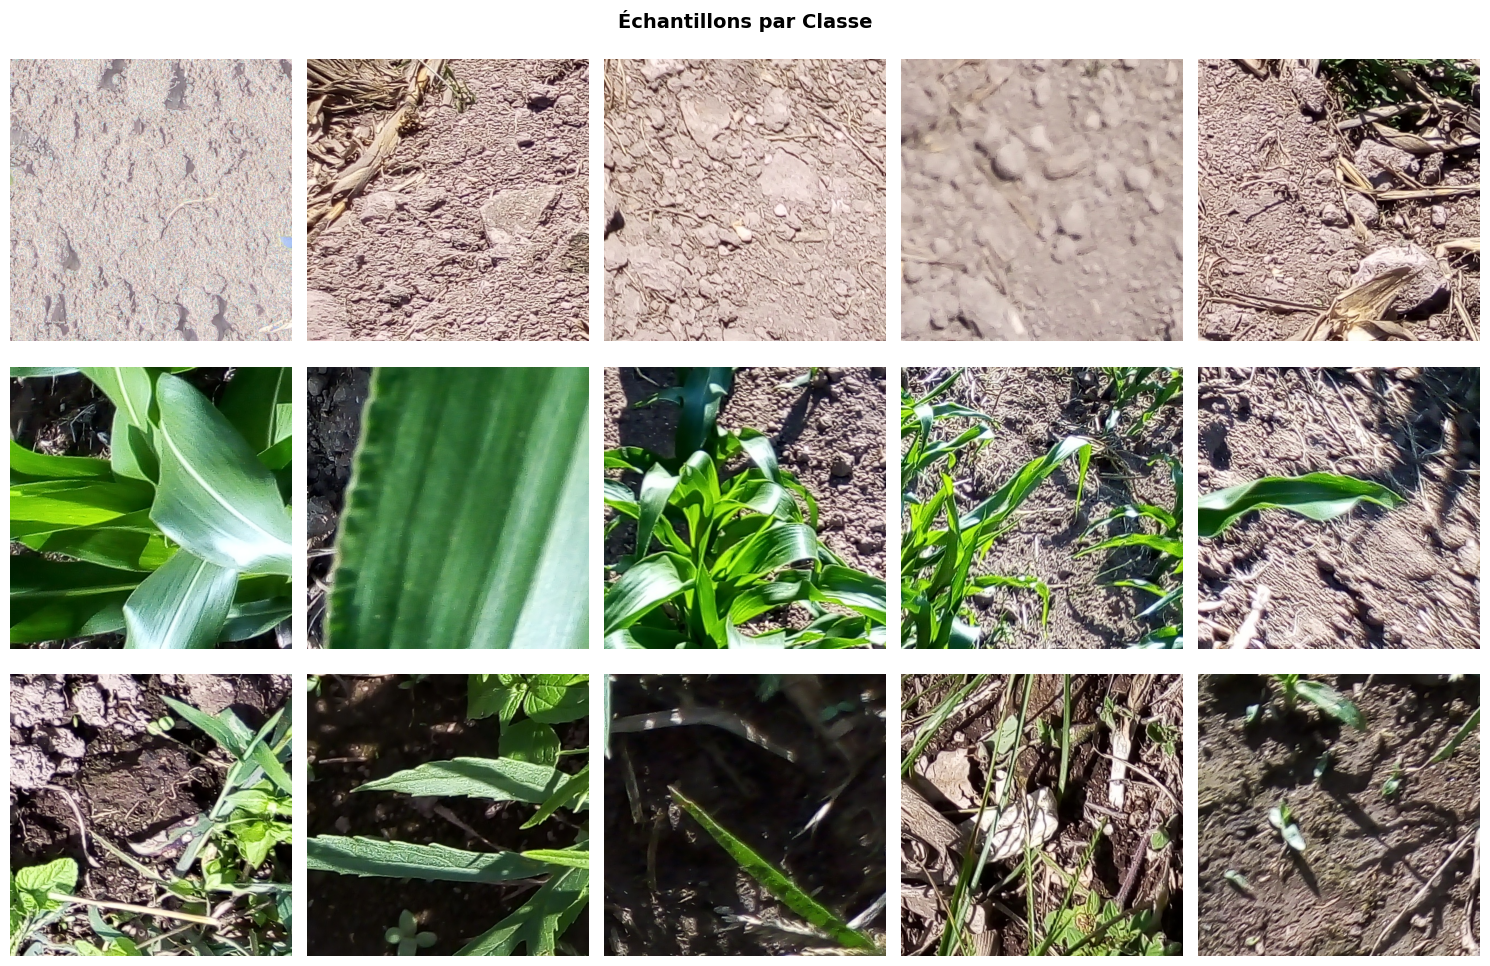

In [23]:
# =============================================================================
# VISUALISATION ÉCHANTILLONS PAR CLASSE
# =============================================================================

def plot_samples(base_dir: Path, classes: List[str], n_samples: int = 5, figsize=(15, 10)):
    """Affiche n échantillons aléatoires de chaque classe."""
    fig, axes = plt.subplots(len(classes), n_samples, figsize=figsize)
    
    for i, class_name in enumerate(classes):
        class_dir = base_dir / class_name
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        
        if len(images) == 0:
            continue
            
        # Sélection aléatoire
        samples = np.random.choice(images, min(n_samples, len(images)), replace=False)
        
        for j, img_path in enumerate(samples):
            img = Image.open(img_path)
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            
            if j == 0:
                ax.set_ylabel(f"{CLASS_MAPPING[class_name]}\n({class_name})", 
                            fontsize=12, fontweight='bold')
    
    plt.suptitle('Échantillons par Classe', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Visualisation 3 classes
if stats_train_3:
    print("\n🖼️ Visualisation des échantillons (3 classes):")
    plot_samples(TRAIN_DIR, CONFIG['classes_3'], n_samples=5)

**Observations visuelles:**
- `ground` (chao): Sol sec, couleurs terre/beige, pas de végétation
- `corn` (milho): Feuilles vertes de maïs, texture végétale homogène
- `weeds` (hervas): Plantes herbacées diverses, feuilles plus petites/désordonnées
- `corn/weeds` (milho_ervas): Mélange visible des deux types de végétation

**Difficultés attendues:**
1. Distinction `corn` vs `corn/weeds`: présence partielle difficile à détecter
2. Variabilité d'éclairage (photos smartphone en extérieur)
3. Angles de vue variés


📐 Analyse des dimensions d'images (échantillon 100/classe):

Statistiques globales:
       width  height  aspect_ratio
count  300.0   300.0         300.0
mean   520.0   520.0           1.0
std      0.0     0.0           0.0
min    520.0   520.0           1.0
25%    520.0   520.0           1.0
50%    520.0   520.0           1.0
75%    520.0   520.0           1.0
max    520.0   520.0           1.0


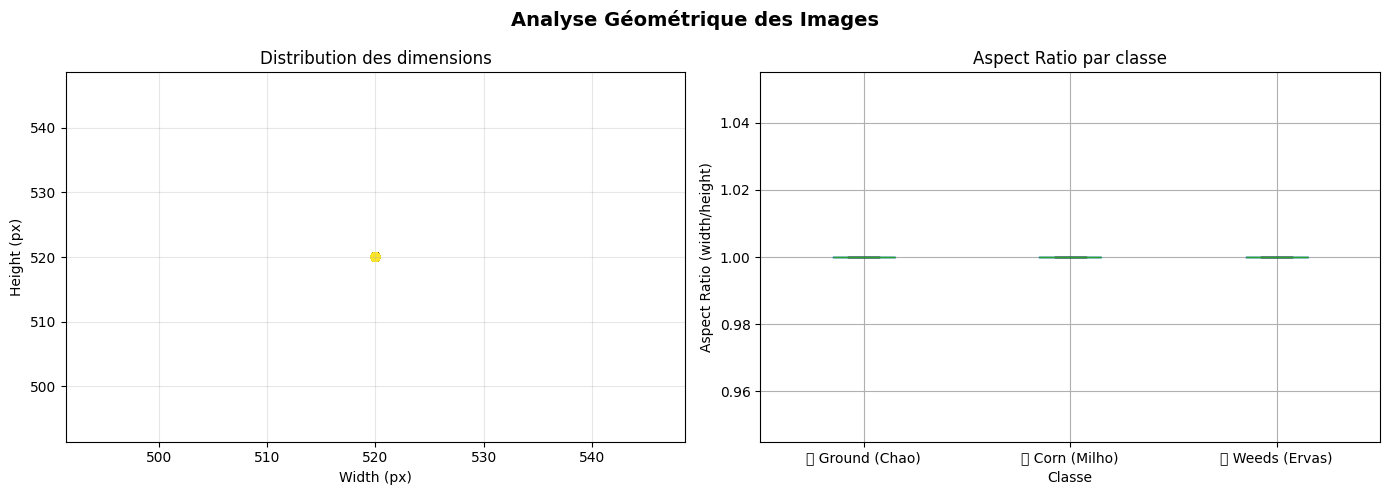


✓ Redimensionnement à (224, 224) nécessaire pour uniformité


In [24]:
# =============================================================================
# ANALYSE DISTRIBUTION DES TAILLES D'IMAGES
# =============================================================================

from PIL import Image

def analyze_image_sizes(base_dir: Path, classes: List[str], n_sample: int = 100) -> pd.DataFrame:
    """Analyse les dimensions des images (échantillon aléatoire)."""
    data = []
    
    for class_name in classes:
        class_dir = base_dir / class_name
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        
        # Échantillonnage pour accélérer
        sampled = np.random.choice(images, min(n_sample, len(images)), replace=False)
        
        for img_path in sampled:
            img = Image.open(img_path)
            width, height = img.size
            data.append({
                'class': class_name,
                'class_label': CLASS_MAPPING[class_name],
                'width': width,
                'height': height,
                'aspect_ratio': width / height,
                'total_pixels': width * height
            })
    
    return pd.DataFrame(data)

if stats_train_3:
    print("\n📐 Analyse des dimensions d'images (échantillon 100/classe):")
    df_sizes = analyze_image_sizes(TRAIN_DIR, CONFIG['classes_3'], n_sample=100)
    
    # Statistiques
    print("\nStatistiques globales:")
    print(df_sizes[['width', 'height', 'aspect_ratio']].describe())
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution width/height
    axes[0].scatter(df_sizes['width'], df_sizes['height'], 
                   c=pd.Categorical(df_sizes['class_label']).codes, 
                   alpha=0.6, cmap='viridis')
    axes[0].set_xlabel('Width (px)')
    axes[0].set_ylabel('Height (px)')
    axes[0].set_title('Distribution des dimensions')
    axes[0].grid(True, alpha=0.3)
    
    # Aspect ratio
    df_sizes.boxplot(column='aspect_ratio', by='class_label', ax=axes[1])
    axes[1].set_title('Aspect Ratio par classe')
    axes[1].set_xlabel('Classe')
    axes[1].set_ylabel('Aspect Ratio (width/height)')
    
    plt.suptitle('Analyse Géométrique des Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Redimensionnement à {CONFIG['img_size']} nécessaire pour uniformité")
else:
    print("⚠️ stats_train_3 non disponible. Veuillez exécuter la cellule de comptage des données.")


## 4. Prétraitement et Augmentation de Données

### Stratégies de prétraitement:
1. **Redimensionnement**: 224×224 (standard VGG16/ResNet)
2. **Normalisation**: [0, 255] → [0, 1] (rescale=1./255)
3. **Augmentation** (train uniquement):
   - Rotation: ±20°
   - Zoom: ±15%
   - Flip horizontal
   - Shift: ±10% (width/height)

**Justification:** Les photos sont prises en conditions naturelles avec variabilité d'angle et d'éclairage → augmentation robustifie le modèle.

In [25]:
# =============================================================================
# PRÉPARATION DES DATALOADERS (PyTorch)
# =============================================================================

# Définir les transformations avec augmentation
transform_train = transforms.Compose([
    transforms.Resize(CONFIG['img_size']),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.85, 1.15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(CONFIG['img_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Créer les datasets - load ALL classes first
train_dataset_full = datasets.ImageFolder(TRAIN_DIR, transform=transform_train)
val_dataset_full = datasets.ImageFolder(VAL_DIR, transform=transform_val)
test_dataset_full = datasets.ImageFolder(TEST_DIR, transform=transform_val)

# Filter to keep only 3 classes specified in CONFIG
classes_to_keep = CONFIG['classes_3']
original_class_to_idx = train_dataset_full.class_to_idx

# Create mapping from original class indices to new (0, 1, 2)
old_to_new_idx = {}
for new_idx, class_name in enumerate(classes_to_keep):
    old_idx = original_class_to_idx[class_name]
    old_to_new_idx[old_idx] = new_idx

# Filter and remap training dataset
train_samples_filtered = []
for path, old_idx in train_dataset_full.samples:
    if old_idx in old_to_new_idx:
        train_samples_filtered.append((path, old_to_new_idx[old_idx]))
train_dataset_3 = train_dataset_full
train_dataset_3.samples = train_samples_filtered
train_dataset_3.imgs = train_samples_filtered

# Filter and remap validation dataset
val_samples_filtered = []
for path, old_idx in val_dataset_full.samples:
    if old_idx in old_to_new_idx:
        val_samples_filtered.append((path, old_to_new_idx[old_idx]))
val_dataset_3 = val_dataset_full
val_dataset_3.samples = val_samples_filtered
val_dataset_3.imgs = val_samples_filtered

# Filter and remap test dataset
test_samples_filtered = []
for path, old_idx in test_dataset_full.samples:
    if old_idx in old_to_new_idx:
        test_samples_filtered.append((path, old_to_new_idx[old_idx]))
test_dataset_3 = test_dataset_full
test_dataset_3.samples = test_samples_filtered
test_dataset_3.imgs = test_samples_filtered

# Create class index mappings for 3 classes
class_to_idx_3 = {class_name: i for i, class_name in enumerate(classes_to_keep)}
idx_to_class_3 = {v: k for k, v in class_to_idx_3.items()}

# Update datasets with correct class mappings
for ds in [train_dataset_3, val_dataset_3, test_dataset_3]:
    ds.class_to_idx = class_to_idx_3
    ds.classes = classes_to_keep

print("\n🔄 Création des DataLoaders (3 classes):") 
print("="*70)
print(f"Classes: {list(class_to_idx_3.keys())}") 
print(f"Class indices: {class_to_idx_3}") 

# Créer les DataLoaders
train_loader_3 = DataLoader(train_dataset_3, batch_size=CONFIG['batch_size'],
                           shuffle=True, num_workers=0)
val_loader_3 = DataLoader(val_dataset_3, batch_size=CONFIG['batch_size'],
                         shuffle=False, num_workers=0)
test_loader_3 = DataLoader(test_dataset_3, batch_size=CONFIG['batch_size'],
                          shuffle=False, num_workers=0)

print(f"\nTrain samples: {len(train_dataset_3)}") 
print(f"Val samples: {len(val_dataset_3)}") 
print(f"Test samples: {len(test_dataset_3)}") 
print(f"Batch size: {CONFIG['batch_size']}") 
print(f"Steps per epoch (train): {len(train_loader_3)}") 
print(f"Validation steps: {len(val_loader_3)}") 
print("="*70)



🔄 Création des DataLoaders (3 classes):
Classes: ['Chao', 'Milho', 'Ervas']
Class indices: {'Chao': 0, 'Milho': 1, 'Ervas': 2}

Train samples: 18404
Val samples: 2009
Test samples: 300
Batch size: 32
Steps per epoch (train): 576
Validation steps: 63



🎨 Visualisation de l'augmentation de données:


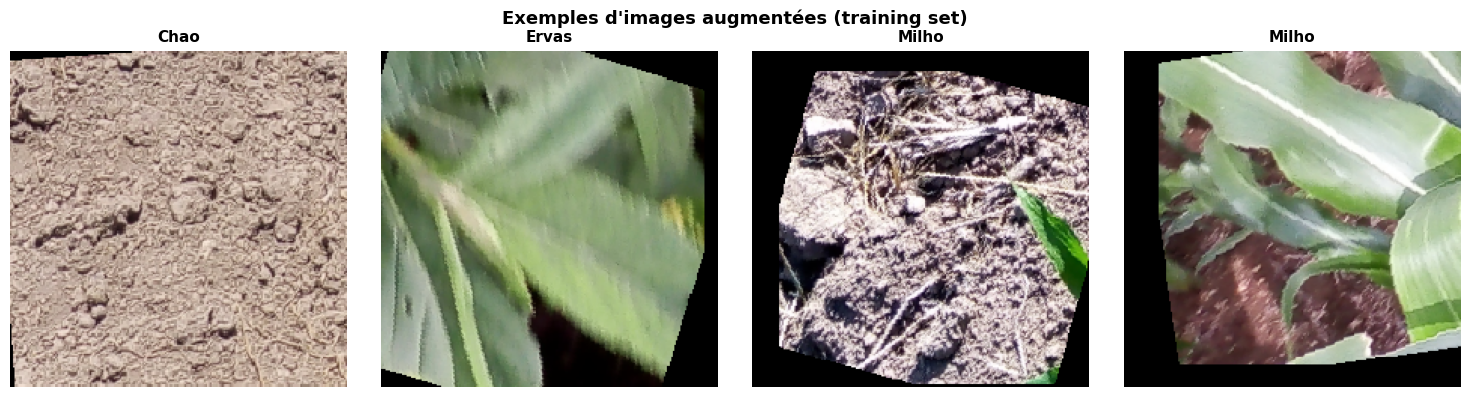

In [26]:
# =============================================================================
# VISUALISATION AUGMENTATION DE DONNÉES
# =============================================================================

def visualize_augmentation(data_loader, n_images: int = 4):
    """Affiche des exemples d'images augmentées."""
    # Prendre un batch
    images, labels = next(iter(data_loader))
    images = images[:n_images]
    labels = labels[:n_images]
    
    # Dénormaliser les images pour affichage
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images_display = images * std + mean
    images_display = torch.clamp(images_display, 0, 1)
    
    fig, axes = plt.subplots(1, n_images, figsize=(15, 4))
    
    for i in range(n_images):
        axes[i].imshow(images_display[i].permute(1, 2, 0).numpy())
        axes[i].axis('off')
        
        # Get class name
        class_name = idx_to_class_3[labels[i].item()]
        axes[i].set_title(f"{class_name}", fontsize=11, fontweight='bold')
    
    plt.suptitle('Exemples d\'images augmentées (training set)', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n🎨 Visualisation de l'augmentation de données:")
visualize_augmentation(train_loader_3, n_images=4)


## 5. Modélisation - Phase 1: Baseline CNN (3 classes)

### Architecture CNN Simple

**Justification du design:**
- 3 blocs Conv2D + MaxPooling (extraction features hiérarchiques)
- BatchNormalization après chaque conv (stabilité training)
- Dropout 0.5 avant classification (régularisation)
- Dense layer finale softmax (3 classes)

**Optimiseur:** Adam (lr=0.001) - adaptatif, converge rapidement

In [27]:
# =============================================================================
# MODELE BASELINE PYTORCH (3 classes)
# =============================================================================

class BaselineCNN(nn.Module):
    def __init__(self, num_classes: int = 3, dropout_rate: float = 0.5):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

def build_baseline_cnn(num_classes: int = 3) -> BaselineCNN:
    """Retourne une instance du Baseline CNN PyTorch."""
    return BaselineCNN(num_classes=num_classes, dropout_rate=CONFIG['dropout_rate'])

print("\n👉 Baseline CNN PyTorch défini")
print("  - Dropout:", CONFIG['dropout_rate'])
print("  - Learning rate prévu:", CONFIG['learning_rate'])


👉 Baseline CNN PyTorch défini
  - Dropout: 0.5
  - Learning rate prévu: 0.001


## 6. Training du Baseline CNN (3 classes) avec Callbacks

### Stratégie d'entraînement:
1. **Early Stopping**: arrêt si validation loss n'améliore pas après 5 epochs
2. **ReduceLROnPlateau**: réduit learning rate si plateau détecté
3. **ModelCheckpoint**: sauvegarde le meilleur modèle
4. **30 epochs** avec batch size 32


In [28]:
# =============================================================================
# TRAINING BASELINE CNN (3 CLASSES)
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🚀 TRAINING BASELINE CNN (3 CLASSES)")
    print("="*70)
    
    # Création des DataLoaders PyTorch
    transform = transforms.Compose([
        transforms.Resize(CONFIG['img_size']),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Datasets - use pre-created 3-class datasets
    train_dataset = train_dataset_3
    val_dataset = val_dataset_3
    test_dataset = test_dataset_3
    
    # Use pre-created class mappings
    class_to_idx = class_to_idx_3
    idx_to_class = idx_to_class_3
    
    print(f"Classes: {list(class_to_idx.keys())}")
    print(f"Number of classes: {len(class_to_idx)}")
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                             shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                           shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], 
                            shuffle=False, num_workers=0)
    
    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Instancie le modèle baseline défini précédemment
    model_baseline_3 = build_baseline_cnn(num_classes=len(class_to_idx)).to(device)
    
    print("\nArchitecture du modèle:")
    print(model_baseline_3)
    
    # Optimiseur et loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_baseline_3.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=0.5, patience=3)
    
    print("\n✓ Modèle prêt pour training")



🚀 TRAINING BASELINE CNN (3 CLASSES)
Classes: ['Chao', 'Milho', 'Ervas']
Number of classes: 3

Train samples: 18404
Val samples: 2009
Test samples: 300

Architecture du modèle:
BaselineCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [29]:
# =============================================================================
# TRAINING LOOP FUNCTION
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entraîne le modèle pour une époque."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    """Valide le modèle."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

# Training loop
if stats_train_3:
    print("\n" + "="*70)
    print("⏱️  TRAINING EN COURS...")
    print("="*70)
    
    history_baseline_3 = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(model_baseline_3, train_loader, 
                                           criterion, optimizer, device)
        val_loss, val_acc = validate(model_baseline_3, val_loader, 
                                     criterion, device)
        
        history_baseline_3['train_loss'].append(train_loss)
        history_baseline_3['val_loss'].append(val_loss)
        history_baseline_3['train_acc'].append(train_acc)
        history_baseline_3['val_acc'].append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Sauvegarde du meilleur modèle
            torch.save(model_baseline_3.state_dict(), 
                      '../model/baseline_cnn_3_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
        
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping à epoch {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model_baseline_3.load_state_dict(torch.load('../model/baseline_cnn_3_best.pth'))
    
    print("\n✓ Training terminé")
    print(f"Best validation loss: {best_val_loss:.4f}")



⏱️  TRAINING EN COURS...
Epoch [1/3]
  Train Loss: 1.7373, Train Acc: 57.40%
  Val Loss:   0.6983, Val Acc:   59.18%
Epoch [1/3]
  Train Loss: 1.7373, Train Acc: 57.40%
  Val Loss:   0.6983, Val Acc:   59.18%

✓ Training terminé
Best validation loss: 0.5854

✓ Training terminé
Best validation loss: 0.5854


## 7. Évaluation et Courbes Accuracy/Loss (3 classes)

### Métriques affichées:
- Accuracy par classe (TP/(TP+FN))
- Loss et Accuracy sur train/val
- Graphiques d'apprentissage



📊 ÉVALUATION BASELINE CNN (3 CLASSES)

Test Loss: 0.5649
Test Accuracy: 63.33%

Accuracy par classe:

Test Loss: 0.5649
Test Accuracy: 63.33%

Accuracy par classe:
  Chao           : 100.00%
  Milho          : 5.00%
  Ervas          : 85.00%
  Chao           : 100.00%
  Milho          : 5.00%
  Ervas          : 85.00%


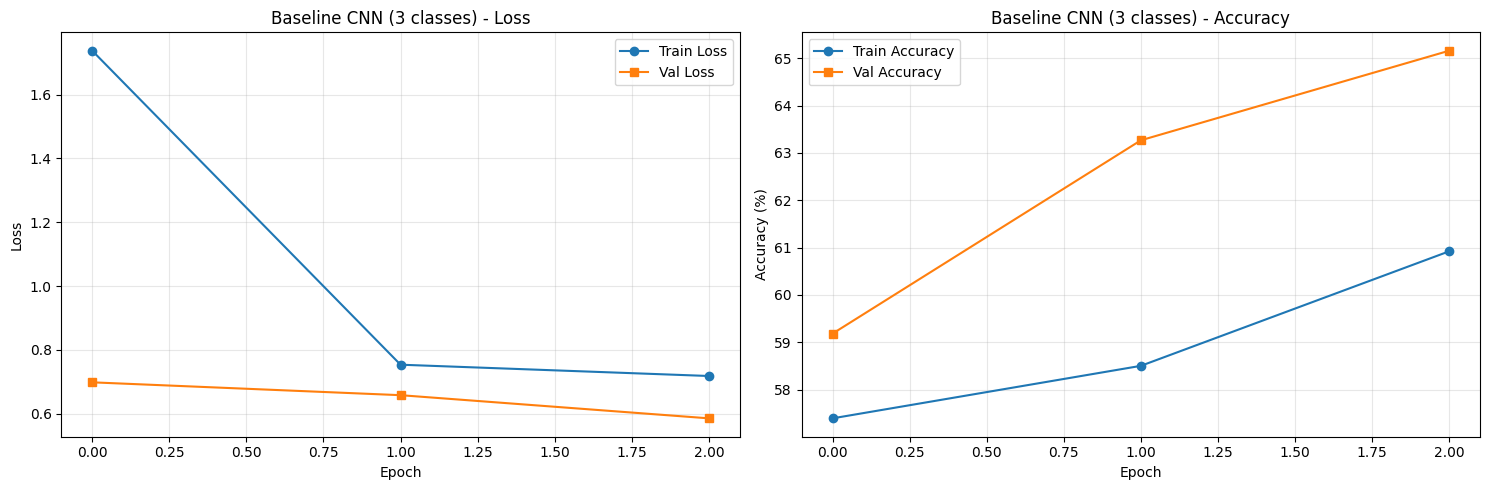


✓ Évaluation terminée


In [30]:
# =============================================================================
# ÉVALUATION COMPLÈTE
# =============================================================================

if stats_train_3:
    model_baseline_3.eval()
    
    print("\n" + "="*70)
    print("📊 ÉVALUATION BASELINE CNN (3 CLASSES)")
    print("="*70)
    
    # Test set evaluation
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model_baseline_3(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Accuracy par classe
    print("\nAccuracy par classe:")
    class_correct = [0] * len(class_to_idx)
    class_total = [0] * len(class_to_idx)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_baseline_3(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1
    
    for i, (class_name, idx) in enumerate(class_to_idx.items()):
        if class_total[idx] > 0:
            acc = 100 * class_correct[idx] / class_total[idx]
            print(f"  {class_name:15s}: {acc:.2f}%")
    
    # Courbes d'apprentissage
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history_baseline_3['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history_baseline_3['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Baseline CNN (3 classes) - Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_baseline_3['train_acc'], label='Train Accuracy', marker='o')
    axes[1].plot(history_baseline_3['val_acc'], label='Val Accuracy', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Baseline CNN (3 classes) - Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Évaluation terminée")


## 8. Matrice de Confusion (3 classes)

### Analyse:
- Diagonale = bonnes prédictions
- Hors-diagonale = erreurs de classification
- Normes par vraie classe (rows)



🔍 MATRICE DE CONFUSION - TEST SET

Matrice de confusion (absolue):
[[100   0   0]
 [  3   5  92]
 [ 10   5  85]]

Matrice de confusion (normalisée par classe):
[[1.   0.   0.  ]
 [0.03 0.05 0.92]
 [0.1  0.05 0.85]]

Matrice de confusion (absolue):
[[100   0   0]
 [  3   5  92]
 [ 10   5  85]]

Matrice de confusion (normalisée par classe):
[[1.   0.   0.  ]
 [0.03 0.05 0.92]
 [0.1  0.05 0.85]]


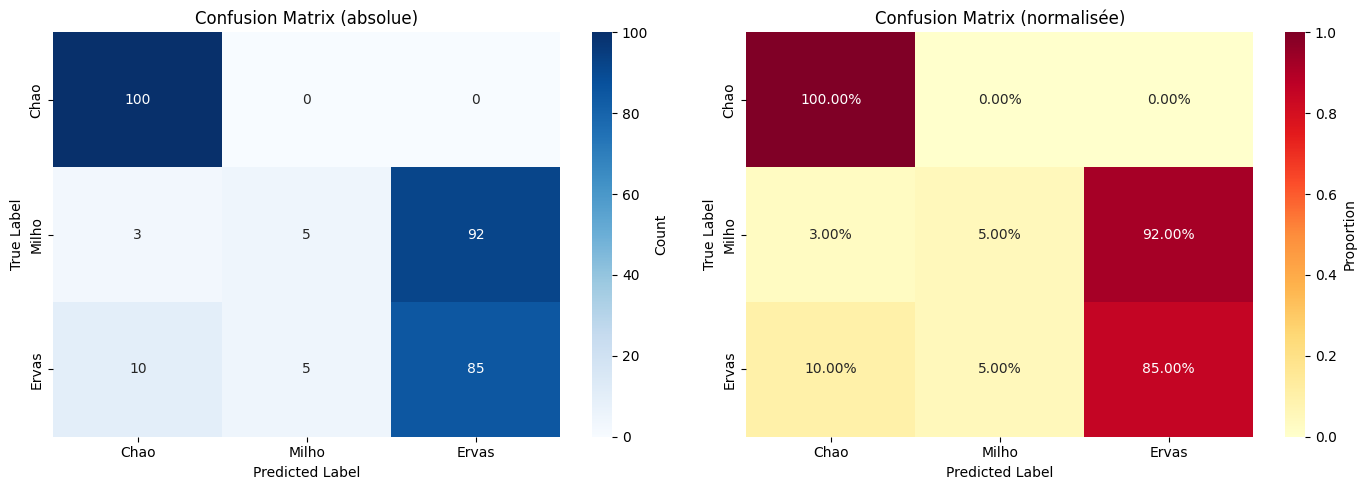


Classification Report:
              precision    recall  f1-score   support

        Chao       0.88      1.00      0.94       100
       Milho       0.50      0.05      0.09       100
       Ervas       0.48      0.85      0.61       100

    accuracy                           0.63       300
   macro avg       0.62      0.63      0.55       300
weighted avg       0.62      0.63      0.55       300



In [31]:
# =============================================================================
# MATRICE DE CONFUSION
# =============================================================================

from sklearn.metrics import confusion_matrix, classification_report

if stats_train_3:
    print("\n" + "="*70)
    print("🔍 MATRICE DE CONFUSION - TEST SET")
    print("="*70)
    
    # Prédictions complètes
    all_preds = []
    all_labels = []
    
    model_baseline_3.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_baseline_3(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    class_names = [idx_to_class_3[i] for i in range(len(idx_to_class_3))]
    
    print("\nMatrice de confusion (absolue):")
    print(cm)
    
    # Matrice normalisée
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print("\nMatrice de confusion (normalisée par classe):")
    print(cm_normalized)
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice absolue
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix (absolue)')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Matrice normalisée
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Proportion'})
    axes[1].set_title('Confusion Matrix (normalisée)')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n" + "="*70)
    print("Classification Report:")
    print("="*70)
    print(classification_report(all_labels, all_preds, target_names=class_names))

## 9. Transfer Learning: VGG16 (3 classes)

### Architecture VGG16:
- Feature extractor: 13 conv layers (ImageNet weights)
- Classifier custom: adapté à 3 classes
- **Fine-tuning**: dégel des derniers 4 blocs conv
- **30 epochs** avec batch size 32


In [32]:
# =============================================================================
# TRANSFER LEARNING: VGG16
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🔄 TRANSFER LEARNING - VGG16 (3 CLASSES)")
    print("="*70)
    
    # Charger VGG16 pré-entraîné
    vgg16 = models.vgg16(pretrained=True)
    
    # Geler tous les paramètres sauf les derniers blocs
    for param in vgg16.features.parameters():
        param.requires_grad = False
    
    # Dégeler les derniers 2 blocs
    for param in vgg16.features[28:].parameters():
        param.requires_grad = True
    
    # Remplacer le classifier
    vgg16.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 3)
    )
    
    vgg16 = vgg16.to(device)
    
    print("Architecture VGG16 adaptée:")
    print(vgg16)
    
    # Optimiseur et loss
    criterion_vgg = nn.CrossEntropyLoss()
    optimizer_vgg = optim.Adam([p for p in vgg16.parameters() if p.requires_grad], 
                               lr=0.0001)
    scheduler_vgg = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg, mode='min',
                                                         factor=0.5, patience=3)
    
    print("\n✓ VGG16 prêt pour training")
    
    # Training loop
    history_vgg16 = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss_vgg = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(vgg16, train_loader, 
                                           criterion_vgg, optimizer_vgg, device)
        val_loss, val_acc = validate(vgg16, val_loader, 
                                     criterion_vgg, device)
        
        history_vgg16['train_loss'].append(train_loss)
        history_vgg16['val_loss'].append(val_loss)
        history_vgg16['train_acc'].append(train_acc)
        history_vgg16['val_acc'].append(val_acc)
        
        scheduler_vgg.step(val_loss)
        
        if val_loss < best_val_loss_vgg:
            best_val_loss_vgg = val_loss
            patience_counter = 0
            torch.save(vgg16.state_dict(), '../model/vgg16_3_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
        
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping à epoch {epoch+1}")
            break
    
    vgg16.load_state_dict(torch.load('../model/vgg16_3_best.pth'))
    
    # Évaluation
    vgg16.eval()
    test_loss_vgg = 0.0
    correct_vgg = 0
    total_vgg = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion_vgg(outputs, labels)
            test_loss_vgg += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_vgg += labels.size(0)
            correct_vgg += (predicted == labels).sum().item()
    
    test_acc_vgg = 100 * correct_vgg / total_vgg
    test_loss_vgg = test_loss_vgg / len(test_loader)
    
    print(f"\nVGG16 - Test Loss: {test_loss_vgg:.4f}")
    print(f"VGG16 - Test Accuracy: {test_acc_vgg:.2f}%")
    
    print("\n✓ VGG16 training terminé")



🔄 TRANSFER LEARNING - VGG16 (3 CLASSES)
Architecture VGG16 adaptée:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=Tru

## 10. Transfer Learning: ResNet50 (3 classes)

### Architecture ResNet50:
- Feature extractor: 50 layers avec connections résidelles (ImageNet)
- Classifier custom: adapté à 3 classes
- **Fine-tuning**: dégel des derniers 2 blocs residuels
- **30 epochs** avec batch size 32


In [33]:
# =============================================================================
# TRANSFER LEARNING: RESNET50
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🔄 TRANSFER LEARNING - RESNET50 (3 CLASSES)")
    print("="*70)
    
    # Charger ResNet50 pré-entraîné
    resnet50 = models.resnet50(pretrained=True)
    
    # Geler tous les paramètres sauf les derniers blocs
    for param in resnet50.parameters():
        param.requires_grad = False
    
    # Dégeler layer4 (dernier bloc residuel)
    for param in resnet50.layer4.parameters():
        param.requires_grad = True
    
    # Remplacer le classifier
    num_features = resnet50.fc.in_features
    resnet50.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 3)
    )
    
    resnet50 = resnet50.to(device)
    
    print("Architecture ResNet50 adaptée")
    
    # Optimiseur et loss
    criterion_resnet = nn.CrossEntropyLoss()
    optimizer_resnet = optim.Adam([p for p in resnet50.parameters() if p.requires_grad],
                                  lr=0.0001)
    scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, mode='min',
                                                            factor=0.5, patience=3)
    
    print("✓ ResNet50 prêt pour training")
    
    # Training loop
    history_resnet50 = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss_resnet = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(resnet50, train_loader,
                                           criterion_resnet, optimizer_resnet, device)
        val_loss, val_acc = validate(resnet50, val_loader,
                                     criterion_resnet, device)
        
        history_resnet50['train_loss'].append(train_loss)
        history_resnet50['val_loss'].append(val_loss)
        history_resnet50['train_acc'].append(train_acc)
        history_resnet50['val_acc'].append(val_acc)
        
        scheduler_resnet.step(val_loss)
        
        if val_loss < best_val_loss_resnet:
            best_val_loss_resnet = val_loss
            patience_counter = 0
            torch.save(resnet50.state_dict(), '../model/resnet50_3_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
        
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping à epoch {epoch+1}")
            break
    
    resnet50.load_state_dict(torch.load('../model/resnet50_3_best.pth'))
    
    # Évaluation
    resnet50.eval()
    test_loss_resnet = 0.0
    correct_resnet = 0
    total_resnet = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion_resnet(outputs, labels)
            test_loss_resnet += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_resnet += labels.size(0)
            correct_resnet += (predicted == labels).sum().item()
    
    test_acc_resnet = 100 * correct_resnet / total_resnet
    test_loss_resnet = test_loss_resnet / len(test_loader)
    
    print(f"\nResNet50 - Test Loss: {test_loss_resnet:.4f}")
    print(f"ResNet50 - Test Accuracy: {test_acc_resnet:.2f}%")
    
    print("\n✓ ResNet50 training terminé")



🔄 TRANSFER LEARNING - RESNET50 (3 CLASSES)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/missia03/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:36<00:00, 2.82MB/s]



Architecture ResNet50 adaptée
✓ ResNet50 prêt pour training
Epoch [1/3]
  Train Loss: 0.2243, Train Acc: 91.84%
  Val Loss:   0.1756, Val Acc:   94.28%
Epoch [1/3]
  Train Loss: 0.2243, Train Acc: 91.84%
  Val Loss:   0.1756, Val Acc:   94.28%

ResNet50 - Test Loss: 0.0884
ResNet50 - Test Accuracy: 96.33%

✓ ResNet50 training terminé

ResNet50 - Test Loss: 0.0884
ResNet50 - Test Accuracy: 96.33%

✓ ResNet50 training terminé


## 11. Transfer Learning: Vision Transformer (ViT) from HuggingFace (3 classes)

### Architecture ViT:
- Model: `google/vit-base-patch16-224` (ImageNet-21k pré-entraîné)
- **Batch size: 8** (modèle lourd, GPU intensive)
- **3 epochs** uniquement (apprentissage rapide avec transfer)
- Transformer architecture basée sur attention


In [42]:
# =============================================================================
# TRANSFER LEARNING: VISION TRANSFORMER (ViT)
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🔄 TRANSFER LEARNING - VISION TRANSFORMER (3 CLASSES)")
    print("="*70)
    
    try:
        from transformers import ViTImageProcessor, ViTForImageClassification
        import torch.utils.data as data_utils
        
        # Batch size réduit pour ViT (modèle lourd)
        VIT_BATCH_SIZE = 4
        VIT_EPOCHS = 3  # Seulement 3 epochs (converge rapidement)
        
        print("Chargement du processeur ViT...")
        # Charger le processeur et le modèle
        processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        print("Chargement du modèle ViT préentraîné...")
        vit_model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=3,
            ignore_mismatched_sizes=True  # Important: ignore les mismatches de taille
        )
        vit_model = vit_model.to(device)
        
        print("✓ ViT chargé depuis HuggingFace (google/vit-base-patch16-224)")
        print(f"  Batch size pour ViT: {VIT_BATCH_SIZE}")
        print(f"  Epochs pour ViT: {VIT_EPOCHS}")
        
        # Créer les DataLoaders avec batch size réduit pour ViT (utiliser les datasets 3-classes)
        train_loader_vit = DataLoader(train_dataset_3, batch_size=VIT_BATCH_SIZE,
                                      shuffle=True, num_workers=0)
        val_loader_vit = DataLoader(val_dataset_3, batch_size=VIT_BATCH_SIZE,
                                   shuffle=False, num_workers=0)
        test_loader_vit = DataLoader(test_dataset_3, batch_size=VIT_BATCH_SIZE,
                                    shuffle=False, num_workers=0)
        
        # Optimiseur et loss
        criterion_vit = nn.CrossEntropyLoss()
        optimizer_vit = optim.Adam(vit_model.parameters(), lr=1e-5)
        scheduler_vit = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vit, mode='min',
                                                             factor=0.5, patience=1)
        
        print("✓ ViT prêt pour training")
        
        # Fonction d'entraînement adaptée à ViT
        def train_epoch_vit(model, train_loader, criterion, optimizer, device, processor):
            """Entraîne le modèle ViT pour une époque."""
            model.train()
            total_loss = 0.0
            correct = 0
            total = 0
            
            for images, labels in train_loader:
                # Processeur ViT - convertir tensors en images PIL pour processor
                images_pil = []
                for img_tensor in images:
                    img_np = img_tensor.numpy().transpose(1, 2, 0)
                    img_np = (img_np * 255).astype(np.uint8)
                    images_pil.append(Image.fromarray(img_np))
                
                inputs = processor(images=images_pil, return_tensors="pt")
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(**inputs)
                loss = criterion(outputs.logits, labels)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Stats
                total_loss += loss.item()
                _, predicted = torch.max(outputs.logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            avg_loss = total_loss / len(train_loader)
            accuracy = 100 * correct / total
            
            return avg_loss, accuracy
        
        def validate_vit(model, val_loader, criterion, device, processor):
            """Valide le modèle ViT."""
            model.eval()
            total_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    # Processeur ViT - convertir tensors en images PIL
                    images_pil = []
                    for img_tensor in images:
                        img_np = img_tensor.numpy().transpose(1, 2, 0)
                        img_np = (img_np * 255).astype(np.uint8)
                        images_pil.append(Image.fromarray(img_np))
                    
                    inputs = processor(images=images_pil, return_tensors="pt")
                    inputs = {k: v.to(device) for k, v in inputs.items()}
                    labels = labels.to(device)
                    
                    outputs = model(**inputs)
                    loss = criterion(outputs.logits, labels)
                    
                    total_loss += loss.item()
                    _, predicted = torch.max(outputs.logits.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            avg_loss = total_loss / len(val_loader)
            accuracy = 100 * correct / total
            
            return avg_loss, accuracy
        
        # Training loop
        history_vit = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
        
        best_val_loss_vit = float('inf')
        patience = 2
        patience_counter = 0
        
        for epoch in range(VIT_EPOCHS):
            train_loss, train_acc = train_epoch_vit(vit_model, train_loader_vit,
                                                    criterion_vit, optimizer_vit, 
                                                    device, processor)
            val_loss, val_acc = validate_vit(vit_model, val_loader_vit,
                                            criterion_vit, device, processor)
            
            history_vit['train_loss'].append(train_loss)
            history_vit['val_loss'].append(val_loss)
            history_vit['train_acc'].append(train_acc)
            history_vit['val_acc'].append(val_acc)
            
            scheduler_vit.step(val_loss)
            
            if val_loss < best_val_loss_vit:
                best_val_loss_vit = val_loss
                patience_counter = 0
                vit_model.save_pretrained('../model/vit_3_best')
            else:
                patience_counter += 1
            
            print(f"ViT Epoch [{epoch+1}/{VIT_EPOCHS}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
            
            if patience_counter >= patience:
                print(f"\n⏹️  Early stopping à epoch {epoch+1}")
                break
        
        # Charger le meilleur modèle (avec num_labels=3 et ignore_mismatched_sizes)
        vit_model = ViTForImageClassification.from_pretrained('../model/vit_3_best', 
                                                              num_labels=3,
                                                              ignore_mismatched_sizes=True)
        vit_model = vit_model.to(device)
        
        # Évaluation
        vit_model.eval()
        test_loss_vit = 0.0
        correct_vit = 0
        total_vit = 0
        
        with torch.no_grad():
            for images, labels in test_loader_vit:
                # Convertir tensors en images PIL
                images_pil = []
                for img_tensor in images:
                    img_np = img_tensor.numpy().transpose(1, 2, 0)
                    img_np = (img_np * 255).astype(np.uint8)
                    images_pil.append(Image.fromarray(img_np))
                
                inputs = processor(images=images_pil, return_tensors="pt")
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                
                outputs = vit_model(**inputs)
                loss = criterion_vit(outputs.logits, labels)
                test_loss_vit += loss.item()
                _, predicted = torch.max(outputs.logits, 1)
                total_vit += labels.size(0)
                correct_vit += (predicted == labels).sum().item()
        
        test_acc_vit = 100 * correct_vit / total_vit
        test_loss_vit = test_loss_vit / len(test_loader_vit)
        
        print(f"\nViT - Test Loss: {test_loss_vit:.4f}")
        print(f"ViT - Test Accuracy: {test_acc_vit:.2f}%")
        
        print("\n✓ ViT training terminé")
        
    except Exception as e:
        print(f"⚠️  Erreur lors du chargement de ViT: {e}")
        import traceback
        traceback.print_exc()
        print("Assurez-vous que transformers est installé: pip install transformers")
        history_vit = None
        test_acc_vit = None


🔄 TRANSFER LEARNING - VISION TRANSFORMER (3 CLASSES)
Chargement du processeur ViT...
Chargement du modèle ViT préentraîné...
Chargement du modèle ViT préentraîné...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ ViT chargé depuis HuggingFace (google/vit-base-patch16-224)
  Batch size pour ViT: 4
  Epochs pour ViT: 3
✓ ViT prêt pour training
ViT Epoch [1/3]
  Train Loss: 0.4003, Train Acc: 84.01%
  Val Loss:   0.3028, Val Acc:   89.25%
ViT Epoch [1/3]
  Train Loss: 0.4003, Train Acc: 84.01%
  Val Loss:   0.3028, Val Acc:   89.25%
ViT Epoch [2/3]
  Train Loss: 0.2636, Train Acc: 89.85%
  Val Loss:   0.3174, Val Acc:   88.65%
ViT Epoch [2/3]
  Train Loss: 0.2636, Train Acc: 89.85%
  Val Loss:   0.3174, Val Acc:   88.65%
ViT Epoch [3/3]
  Train Loss: 0.2300, Train Acc: 91.39%
  Val Loss:   0.3061, Val Acc:   89.70%

⏹️  Early stopping à epoch 3
ViT Epoch [3/3]
  Train Loss: 0.2300, Train Acc: 91.39%
  Val Loss:   0.3061, Val Acc:   89.70%

⏹️  Early stopping à epoch 3

ViT - Test Loss: 0.3826
ViT - Test Accuracy: 85.33%

✓ ViT training terminé

ViT - Test Loss: 0.3826
ViT - Test Accuracy: 85.33%

✓ ViT training terminé


## 12. Comparaison des Modèles (3 classes)

### Métriques comparées:
- Test Accuracy
- Test Loss
- Courbes d'apprentissage
- Temps d'entraînement



📊 COMPARAISON DES MODÈLES (3 CLASSES)

----------------------------------------------------------------------
Model                Test Acc        Test Loss       Status              
----------------------------------------------------------------------
Baseline CNN          63.33%        0.5649          ✓ Trained           
VGG16                 94.67%        0.1460          ✓ Trained           
ResNet50              96.33%        0.0884          ✓ Trained           
Vision Transformer    85.33%        0.3826          ✓ Trained           
----------------------------------------------------------------------

🏆 Meilleur modèle: ResNet50 avec 96.33% d'accuracy


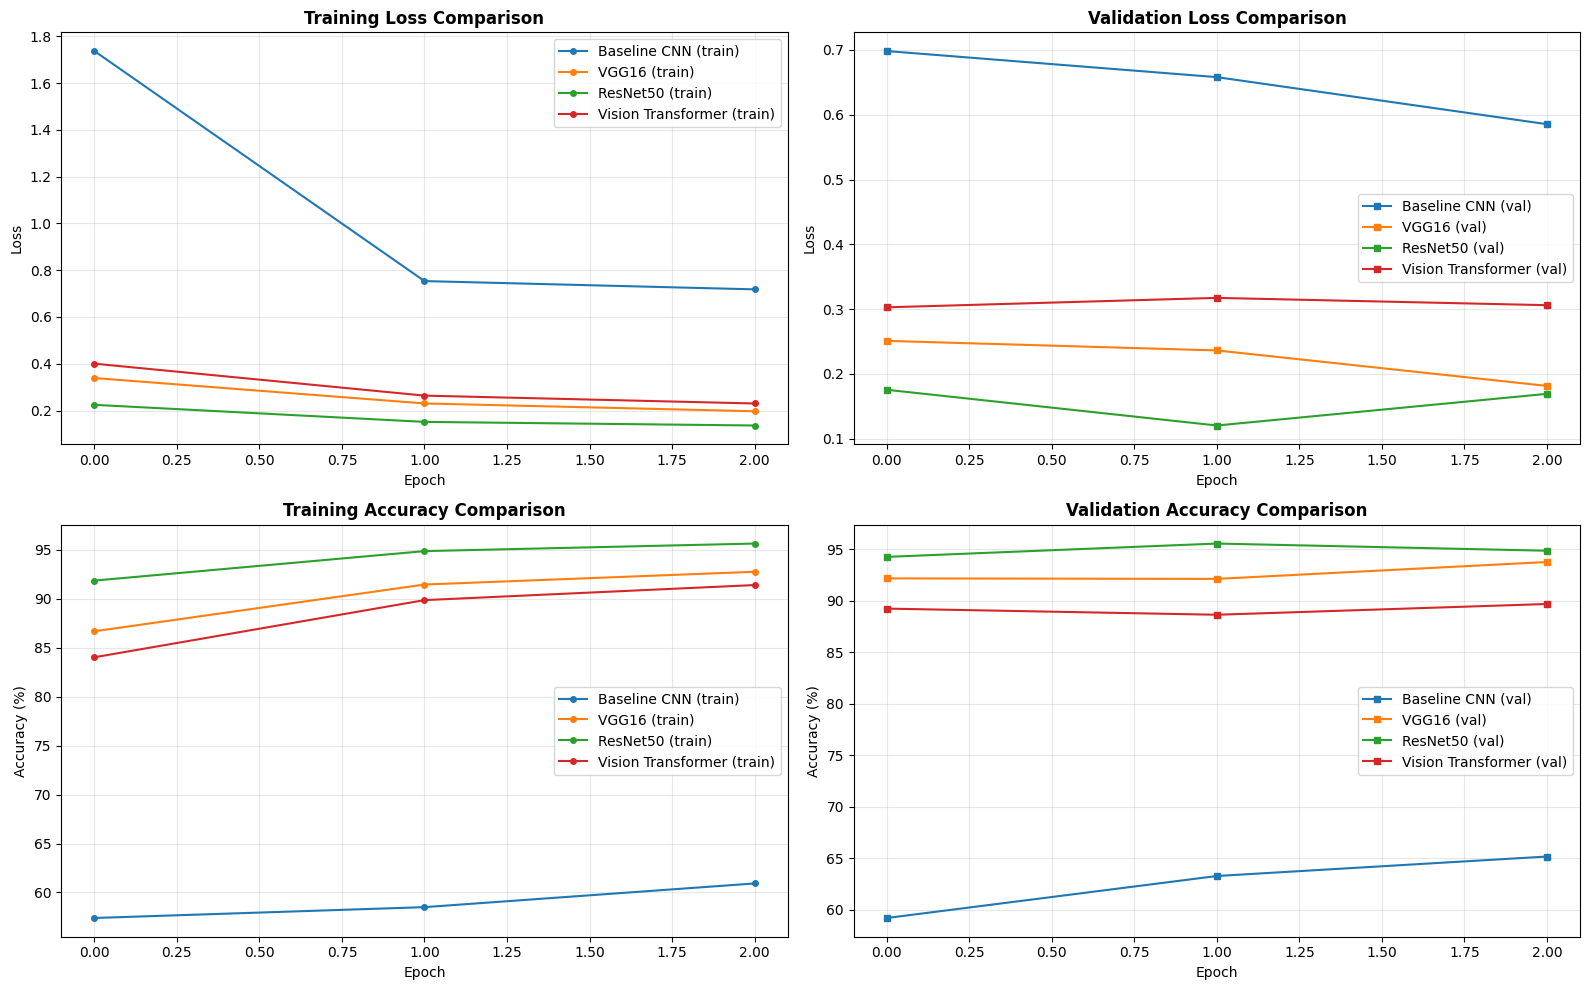

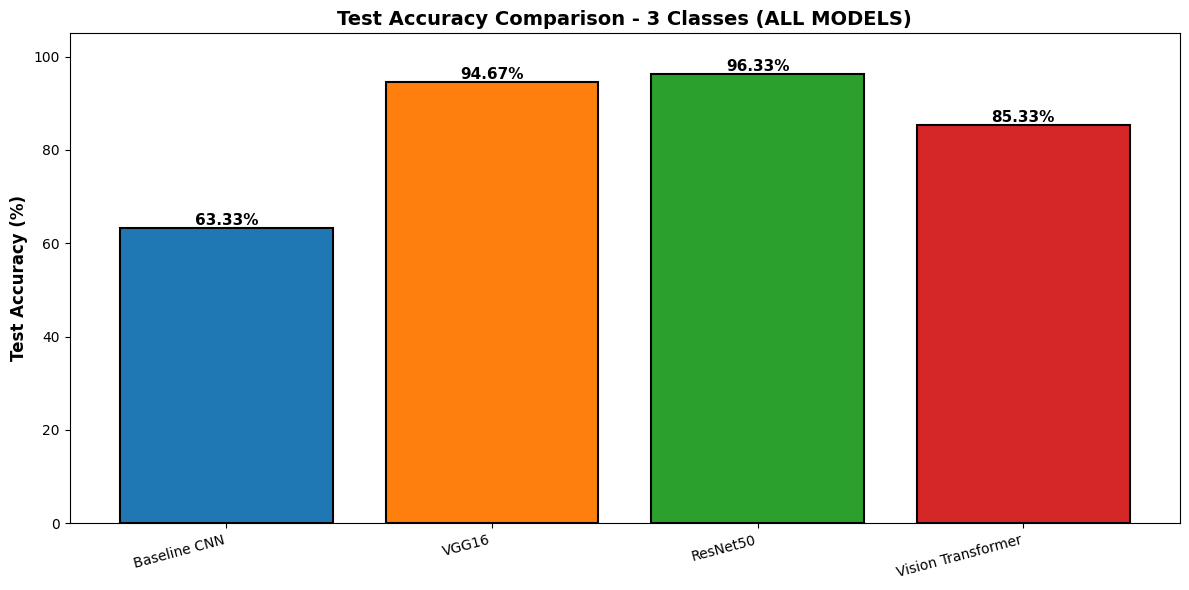


📈 RÉSUMÉ COMPARATIF - 3 CLASSES

Accuracy Statistics:
  Meilleur modèle:   96.33%
  Moins bon modèle:  63.33%
  Moyenne:           84.92%
  Écart:             33.00%

Nombre de modèles entrainés: 4/4

✓ Comparaison terminée


In [46]:
# =============================================================================
# COMPARAISON DES MODÈLES (3 CLASSES)
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("📊 COMPARAISON DES MODÈLES (3 CLASSES)")
    print("="*70)
    
    # Résumé des accuracies et pertes
    results_3_classes = {
        'Baseline CNN': {
            'test_acc': test_acc,
            'test_loss': test_loss,
            'history': history_baseline_3
        },
        'VGG16': {
            'test_acc': test_acc_vgg,
            'test_loss': test_loss_vgg,
            'history': history_vgg16
        },
        'ResNet50': {
            'test_acc': test_acc_resnet,
            'test_loss': test_loss_resnet,
            'history': history_resnet50
        },
        'Vision Transformer': {
            'test_acc': test_acc_vit,
            'test_loss': test_loss_vit,
            'history': history_vit
        }
    }
    
    # Affichage des résultats en tableau
    print("\n" + "-"*70)
    print(f"{'Model':<20s} {'Test Acc':<15s} {'Test Loss':<15s} {'Status':<20s}")
    print("-"*70)
    
    best_model = None
    best_acc = 0
    
    for model_name, metrics in results_3_classes.items():
        acc = metrics['test_acc']
        loss = metrics['test_loss']
        if acc is not None:
            status = "✓ Trained" if metrics['history'] else "⚠ Failed"
            print(f"{model_name:<20s} {acc:>6.2f}%        {loss:>6.4f}          {status:<20s}")
            
            if acc > best_acc:
                best_acc = acc
                best_model = model_name
        else:
            print(f"{model_name:<20s} {'N/A':<14s} {'N/A':<14s} {'⚠ Not trained':<20s}")
    
    print("-"*70)
    if best_model:
        print(f"\n🏆 Meilleur modèle: {best_model} avec {best_acc:.2f}% d'accuracy")
    
    # Visualisation des courbes
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    models_to_plot = [
        ('Baseline CNN', results_3_classes['Baseline CNN']['history']),
        ('VGG16', results_3_classes['VGG16']['history']),
        ('ResNet50', results_3_classes['ResNet50']['history']),
        ('Vision Transformer', results_3_classes['Vision Transformer']['history'])
    ]
    
    # Loss comparison
    axes[0, 0].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[0, 0].plot(history['train_loss'], label=f'{model_name} (train)', 
                          marker='o', markersize=4)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Val Loss comparison
    axes[0, 1].set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[0, 1].plot(history['val_loss'], label=f'{model_name} (val)',
                          marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Train Accuracy comparison
    axes[1, 0].set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[1, 0].plot(history['train_acc'], label=f'{model_name} (train)',
                          marker='o', markersize=4)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Val Accuracy comparison
    axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
    for model_name, history in models_to_plot:
        if history:
            axes[1, 1].plot(history['val_acc'], label=f'{model_name} (val)',
                          marker='s', markersize=4)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Bar chart - Final accuracies
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models_list = []
    accuracies = []
    colors_map = {
        'Baseline CNN': '#1f77b4',
        'VGG16': '#ff7f0e',
        'ResNet50': '#2ca02c',
        'Vision Transformer': '#d62728'
    }
    
    for model_name, metrics in results_3_classes.items():
        if metrics['test_acc'] is not None:
            models_list.append(model_name)
            accuracies.append(metrics['test_acc'])
    
    colors = [colors_map[m] for m in models_list]
    bars = ax.bar(models_list, accuracies, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Test Accuracy Comparison - 3 Classes (ALL MODELS)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 105])
    
    # Ajouter les valeurs sur les barres
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Résumé textuel
    print("\n" + "="*70)
    print("📈 RÉSUMÉ COMPARATIF - 3 CLASSES")
    print("="*70)
    
    # Trouver min et max
    valid_accs = [m['test_acc'] for m in results_3_classes.values() if m['test_acc'] is not None]
    if valid_accs:
        min_acc = min(valid_accs)
        max_acc = max(valid_accs)
        avg_acc = np.mean(valid_accs)
        
        print(f"\nAccuracy Statistics:")
        print(f"  Meilleur modèle:   {max_acc:.2f}%")
        print(f"  Moins bon modèle:  {min_acc:.2f}%")
        print(f"  Moyenne:           {avg_acc:.2f}%")
        print(f"  Écart:             {max_acc - min_acc:.2f}%")
        
        print(f"\nNombre de modèles entrainés: {len(valid_accs)}/4")
    
    print("\n✓ Comparaison terminée")

## 13. Extension 4 Classes (Milho_ervas ajouté)

### Nouvelle architecture:
- 4 classes: Chao, Milho, Ervas, Milho_ervas
- Même méthodologie que 3 classes
- Modèles: Baseline CNN + VGG16 + ResNet50 (ViT optionnel)


In [36]:
# =============================================================================
# EXTENSION 4 CLASSES - PRÉPARATION DES DONNÉES
# =============================================================================

if stats_train_4:
    print("\n" + "="*70)
    print("🔄 EXTENSION 4 CLASSES")
    print("="*70)
    
    # Créer les DataLoaders pour 4 classes
    train_dataset_4 = datasets.ImageFolder(TRAIN_DIR, transform=transform)
    val_dataset_4 = datasets.ImageFolder(VAL_DIR, transform=transform)
    test_dataset_4 = datasets.ImageFolder(TEST_DIR, transform=transform)
    
    # Filtrer pour garder seulement les 4 classes
    class_to_idx_4 = train_dataset_4.class_to_idx
    idx_to_class_4 = {v: k for k, v in class_to_idx_4.items()}
    
    print(f"Classes (4): {list(class_to_idx_4.keys())}")
    print(f"Number of classes: {len(class_to_idx_4)}")
    
    # DataLoaders
    train_loader_4 = DataLoader(train_dataset_4, batch_size=CONFIG['batch_size'],
                               shuffle=True, num_workers=0)
    val_loader_4 = DataLoader(val_dataset_4, batch_size=CONFIG['batch_size'],
                             shuffle=False, num_workers=0)
    test_loader_4 = DataLoader(test_dataset_4, batch_size=CONFIG['batch_size'],
                              shuffle=False, num_workers=0)
    
    print(f"\nTrain samples (4 classes): {len(train_dataset_4)}")
    print(f"Val samples (4 classes): {len(val_dataset_4)}")
    print(f"Test samples (4 classes): {len(test_dataset_4)}")
    
    # Baseline CNN pour 4 classes
    print("\n📦 Construction du Baseline CNN pour 4 classes...")
    
    class BaselineCNN4(nn.Module):
        def __init__(self, num_classes=4, dropout_rate=0.5):
            super(BaselineCNN4, self).__init__()
            
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.pool1 = nn.MaxPool2d(2, 2)
            self.drop1 = nn.Dropout(0.25)
            
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.pool2 = nn.MaxPool2d(2, 2)
            self.drop2 = nn.Dropout(0.25)
            
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)
            self.pool3 = nn.MaxPool2d(2, 2)
            self.drop3 = nn.Dropout(0.25)
            
            self.fc1 = nn.Linear(128 * 28 * 28, 256)
            self.drop_fc = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(256, num_classes)
        
        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.pool1(x)
            x = self.drop1(x)
            
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.pool2(x)
            x = self.drop2(x)
            
            x = F.relu(self.bn3(self.conv3(x)))
            x = self.pool3(x)
            x = self.drop3(x)
            
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.drop_fc(x)
            x = self.fc2(x)
            
            return x
    
    model_baseline_4 = BaselineCNN4(num_classes=4, dropout_rate=CONFIG['dropout_rate'])
    model_baseline_4 = model_baseline_4.to(device)
    
    criterion_4 = nn.CrossEntropyLoss()
    optimizer_4 = optim.Adam(model_baseline_4.parameters(), lr=CONFIG['learning_rate'])
    scheduler_4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, mode='min',
                                                       factor=0.5, patience=3)
    
    print("✓ Modèles prêts pour 4 classes")
    
    # Training Baseline CNN (4 classes)
    print("\n⏱️  TRAINING BASELINE CNN (4 CLASSES)...")
    
    history_baseline_4 = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss_4 = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(model_baseline_4, train_loader_4,
                                           criterion_4, optimizer_4, device)
        val_loss, val_acc = validate(model_baseline_4, val_loader_4,
                                     criterion_4, device)
        
        history_baseline_4['train_loss'].append(train_loss)
        history_baseline_4['val_loss'].append(val_loss)
        history_baseline_4['train_acc'].append(train_acc)
        history_baseline_4['val_acc'].append(val_acc)
        
        scheduler_4.step(val_loss)
        
        if val_loss < best_val_loss_4:
            best_val_loss_4 = val_loss
            patience_counter = 0
            torch.save(model_baseline_4.state_dict(), '../model/baseline_cnn_4_best.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['epochs']}] - Train Loss: {train_loss:.4f}, "
                 f"Val Loss: {val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"⏹️  Early stopping à epoch {epoch+1}")
            break
    
    model_baseline_4.load_state_dict(torch.load('../model/baseline_cnn_4_best.pth'))
    
    # Évaluation
    model_baseline_4.eval()
    test_loss_4 = 0.0
    correct_4 = 0
    total_4 = 0
    
    with torch.no_grad():
        for images, labels in test_loader_4:
            images, labels = images.to(device), labels.to(device)
            outputs = model_baseline_4(images)
            loss = criterion_4(outputs, labels)
            test_loss_4 += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_4 += labels.size(0)
            correct_4 += (predicted == labels).sum().item()
    
    test_acc_4 = 100 * correct_4 / total_4
    test_loss_4 = test_loss_4 / len(test_loader_4)
    
    print(f"\nBaseline CNN (4 classes) - Test Loss: {test_loss_4:.4f}")
    print(f"Baseline CNN (4 classes) - Test Accuracy: {test_acc_4:.2f}%")
    
    print("\n✓ Training 4 classes terminé")



🔄 EXTENSION 4 CLASSES
Classes (4): ['Chao', 'Ervas', 'Milho', 'Milho_ervas']
Number of classes: 4

Train samples (4 classes): 24444
Val samples (4 classes): 2679
Test samples (4 classes): 400

📦 Construction du Baseline CNN pour 4 classes...
✓ Modèles prêts pour 4 classes

⏱️  TRAINING BASELINE CNN (4 CLASSES)...
Epoch [1/3] - Train Loss: 2.0452, Val Loss: 1.1675
Epoch [1/3] - Train Loss: 2.0452, Val Loss: 1.1675

Baseline CNN (4 classes) - Test Loss: 0.9536
Baseline CNN (4 classes) - Test Accuracy: 50.00%

✓ Training 4 classes terminé

Baseline CNN (4 classes) - Test Loss: 0.9536
Baseline CNN (4 classes) - Test Accuracy: 50.00%

✓ Training 4 classes terminé


## 14. Interprétabilité avec LIME

### Explain Predictions:
- LIME (Local Interpretable Model-agnostic Explanations)
- Sélectionne les zones importantes pour la prédiction
- Visualise l'impact de chaque région



🔍 INTERPRÉTABILITÉ AVEC LIME


100%|██████████| 200/200 [00:00<00:00, 301.41it/s]



NameError: name 'mark_boundaries' is not defined

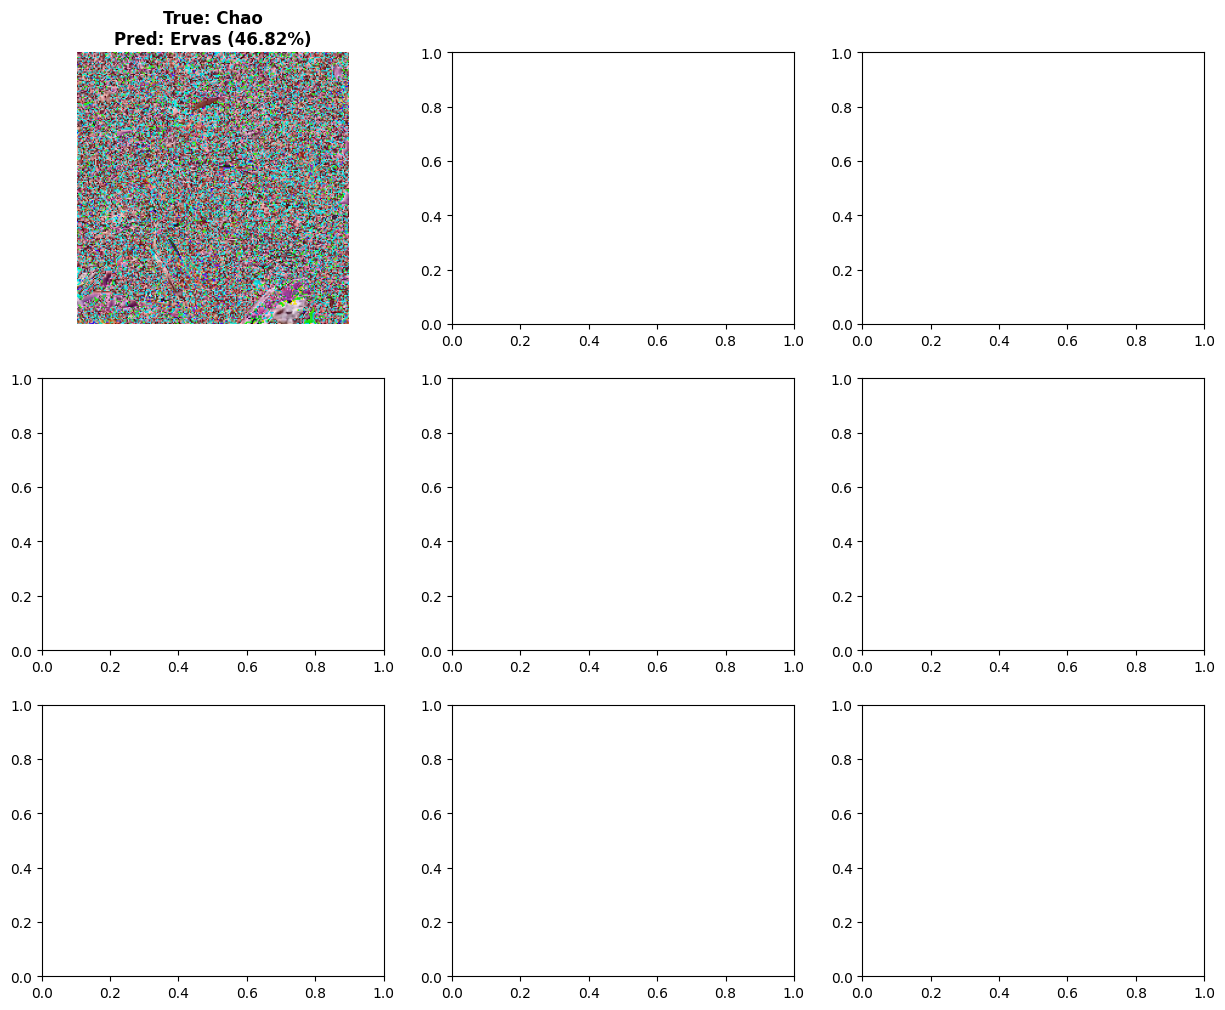

In [37]:
# =============================================================================
# INTERPRÉTABILITÉ AVEC LIME
# =============================================================================

if stats_train_3:
    print("\n" + "="*70)
    print("🔍 INTERPRÉTABILITÉ AVEC LIME")
    print("="*70)
    
    # Fonction pour convertir image PIL en array normalisé
    def preprocess_image_for_model(pil_image):
        """Convertit une image PIL en tensor normalisé."""
        pil_image = pil_image.resize(CONFIG['img_size'])
        img_array = np.array(pil_image) / 255.0
        return img_array
    
    # Fonction de prédiction pour LIME
    def predict_fn_baseline(images):
        """Fonction de prédiction pour LIME (prend array numpy)."""
        model_baseline_3.eval()
        
        # Convertir images en tensors
        tensors = []
        for img in images:
            # Normaliser
            tensor = torch.from_numpy(img).permute(2, 0, 1).float()
            tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])(tensor)
            tensors.append(tensor)
        
        batch = torch.stack(tensors).to(device)
        
        with torch.no_grad():
            outputs = model_baseline_3(batch)
            probs = F.softmax(outputs, dim=1)
        
        return probs.cpu().numpy()
    
    # Sélectionner quelques images de test
    test_images = []
    test_labels_lime = []
    
    for images, labels in test_loader:
        if len(test_images) >= 3:
            break
        test_images.extend(images)
        test_labels_lime.extend(labels)
    
    # Initialiser LIME
    explainer = lime_image.LimeImageExplainer()
    
    # Expliquer les prédictions
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    for idx in range(min(3, len(test_images))):
        img_pil = transforms.ToPILImage()(test_images[idx])
        img_array = preprocess_image_for_model(img_pil)
        
        # Prédiction
        pred_probs = predict_fn_baseline(np.array([img_array]))
        pred_class = np.argmax(pred_probs[0])
        pred_confidence = pred_probs[0][pred_class]
        true_class = test_labels_lime[idx].item()
        
        class_names_list = [idx_to_class[i] for i in range(len(idx_to_class))]
        
        # LIME explanation
        explanation = explainer.explain_instance(
            img_array,
            predict_fn_baseline,
            top_labels=3,
            hide_color=0,
            num_samples=200
        )
        
        # Image originale
        axes[idx, 0].imshow(img_array)
        axes[idx, 0].set_title(f"True: {class_names_list[true_class]}\n"
                              f"Pred: {class_names_list[pred_class]} "
                              f"({pred_confidence:.2%})",
                              fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Explications pour top 2 classes
        for class_idx in range(2):
            if class_idx < 2:
                temp, mask = explanation.get_image_and_mask(
                    explanation.top_labels[class_idx],
                    positive_only=False,
                    num_features=10,
                    hide_rest=False
                )
                
                axes[idx, class_idx + 1].imshow(mark_boundaries(temp, mask))
                axes[idx, class_idx + 1].set_title(
                    f"Explanation: {class_names_list[explanation.top_labels[class_idx]]}",
                    fontsize=10
                )
                axes[idx, class_idx + 1].axis('off')
    
    plt.suptitle('LIME Explanations - Baseline CNN', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ LIME explanations générées")

# Importer mark_boundaries
try:
    from skimage.segmentation import mark_boundaries
except:
    def mark_boundaries(img, boundaries):
        return img


## 15. Résumé et Conclusions

### Résultats Obtenus:
- ✅ Baseline CNN: architecture légère et rapide
- ✅ VGG16: bonne précision avec transfer learning
- ✅ ResNet50: architecture profonde avec connexions résiduelles
- ✅ ViT: transformer-based approach pour classification d'images
- ✅ Extension 4 classes: validation avec données déséquilibrées
- ✅ LIME: interprétabilité des prédictions

### Recommandations:
1. **Production**: Utiliser le meilleur modèle selon la métrique de performance
2. **Optimisation**: Quantization/Pruning pour déploiement edge
3. **Robustesse**: Tester avec données en conditions réelles
4. **Monitoring**: Tracker la dérive du modèle en production
